In [1]:
%reset -f
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pyross

### Load Denmark age structure and contact matrix

In [3]:
## population and age classes
M=4  ## number of age classes

my_data = np.genfromtxt('../data/age_structures/Denmark-2019.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

Ni0=aM+aF;   Ni=np.zeros((M))

Ni[0] = np.sum(Ni0[0:4])
Ni[1] = np.sum(Ni0[4:8])
Ni[2] = np.sum(Ni0[8:12])
Ni[3] = np.sum(Ni0[12:16])
N=np.sum(Ni)

print(Ni)

[1287864. 1437566. 1556036. 1224130.]


In [4]:
# Get individual contact matrices
CH0, CW0, CS0, CO0 = pyross.contactMatrix.Denmark()


CH = np.zeros((M, M))
CW = np.zeros((M, M))
CS = np.zeros((M, M))
CO = np.zeros((M, M))

for i in range(16):
    CH0[i,:] = Ni0[i]*CH0[i,:]
    CS0[i,:] = Ni0[i]*CS0[i,:]
    CW0[i,:] = Ni0[i]*CW0[i,:]
    CO0[i,:] = Ni0[i]*CO0[i,:]

    
for i in range(M):
    for j in range(M):
        i1, j1 = i*4, j*4
        CH[i,j] = np.sum( CH0[i1:i1+4,j1:j1+4]  )/Ni[i]
        CW[i,j] = np.sum( CW0[i1:i1+4,j1:j1+4]  )/Ni[i]
        CS[i,j] = np.sum( CS0[i1:i1+4,j1:j1+4]  )/Ni[i]
        CO[i,j] = np.sum( CO0[i1:i1+4,j1:j1+4]  )/Ni[i]

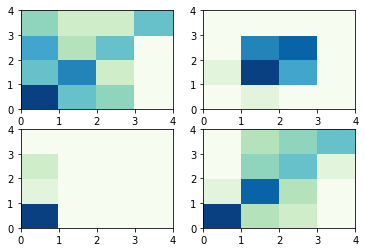

In [5]:
fig,aCF =  plt.subplots(2,2);
aCF[0][0].pcolor(CH, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[0][1].pcolor(CW, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[1][0].pcolor(CS, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[1][1].pcolor(CO, cmap=plt.cm.get_cmap('GnBu', 10));

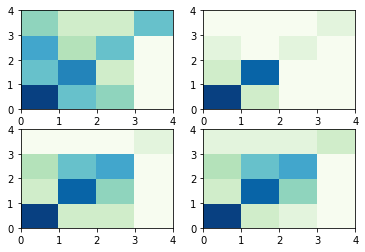

In [6]:
# Create contact matrices for lockdown scenarios

# all locked in
C_0 = CH.copy()

# all but youngest two classes (0-19, 20-39) locked in
C_1 = CH.copy()
C_1[:2,:2] += CW[:2,:2] + CS[:2,:2] + CO[:2,:2]

# all but youngest three classes (0-19, 20-39, 40-59) locked in
C_2 = CH.copy()
C_2[:3,:3] += CW[:3,:3] + CS[:3,:3] + CO[:3,:3]

# nobody locked in
C_3 = CH + CW + CS + CO

C = CH + CW + CS + CO


fig,aCF =  plt.subplots(2,2);
aCF[0][0].pcolor(C_0, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[0][1].pcolor(C_1, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[1][0].pcolor(C_2, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[1][1].pcolor(C_3, cmap=plt.cm.get_cmap('GnBu', 10));

### Define model parameters

In [7]:
beta  = 0.036692            # infection rate 

gE    = 1/8
gA    = 1/3
gIa   = 1./7                # recovery rate of asymptomatic infectives 
gIs   = 1./7                # recovery rate of symptomatic infectives 
alpha = 0.4                 # fraction of asymptomatic infectives 
# https://www.cebm.net/covid-19/covid-19-what-proportion-are-asymptomatic/
fsa   = 0.2                 # the self-isolation parameter   
fh    = 0
gIh   = 1/7
gIc   = 1/14
 
sa    = 0*np.ones(M)      #  rate of additional/removal of population by birth etc
sa[0]     = 0            # birth
sa[3] = 0          # mortality


hh   = 0.1*np.ones(M)       # fraction which goes from Is to hospital
hh[0] = 0.01
hh[1] = 0.05
cc   = 0.05*np.ones(M)      # fraction which goes from  hospital to ICU 
mm   = 0.4*np.ones(M)       # mortality from IC


# initial conditions    
Is_0 = np.zeros((M));  #Is_0[6:13]=8;  Is_0[2:6]=4; Is_0[13:16]=4

#Ia_0 = 130*np.ones((M));  
Ia_0 = 10*np.ones((M));  
R_0  = np.zeros((M))
E_0  = np.zeros((M))
A_0  = np.zeros((M))
Ih_0  = np.zeros((M))
Ic_0  = np.zeros((M))
Im_0  = np.zeros((M))

S_0  = Ni - (E_0 + A_0 + Ia_0 + Is_0 + Ih_0 + Ic_0 +Im_0 + R_0)

In [29]:
# duration of simulation and data file
Tf=150;  Nf=Tf+1;  


# intantiate model
parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,
              'gIh':gIh,'gIc':gIc,  'gE':gE, 'gA':gA,
              'fsa':fsa, 'fh':fh, 
              'sa':sa, 
              'hh':hh, 'cc':cc, 'mm':mm}
model = pyross.control.SEAI5R(parameters, M, Ni.copy())



# the contact structure is independent of time 
def contactMatrix(t):
    return C

events = [lambda t: 1]
contactMatrices = [C]

# Lockdown
lockdown_threshold_0 = 500
def cur_event0(t,rp):
    return np.sum(rp[4*M:7*M]) - lockdown_threshold_0
cur_event0.direction = +1 # this means we need to pass the threshold from below for the event to happen
events.append(cur_event0)
contactMatrices.append( CH + 0.1*CW ) # everybody in lockdown


# Lockdown
lockdown_threshold_1 = 100
def cur_event1(t,rp):
    return t - lockdown_threshold_1 # np.sum(rp[4*M:7*M]) - lockdown_threshold_1
cur_event1.direction = +1 # this means we need to pass the threshold from below for the event to happen
events.append(cur_event1)
contactMatrices.append( CH + 0.1*CW + 0.75*CS ) # everybody in lockdown


# run model
data=model.simulate(S_0, E_0, A_0, Ia_0, Is_0, Ih_0, Ic_0, Im_0,
                    events,contactMatrices, Tf, Nf,
                                method='gillespie')




t = data['t']; IC  = np.zeros((Nf))
for i in range(2*M):
        IC += data['X'][:,M+i]
        
'''
fig,ax = plt.subplots(1,1,figsize=(10,6))
for i,e in enumerate(data['X'].T):
    if np.min(e) > 10000: continue
    ax.plot(t,e)
plt.show(fig)
plt.close(fig)
''';

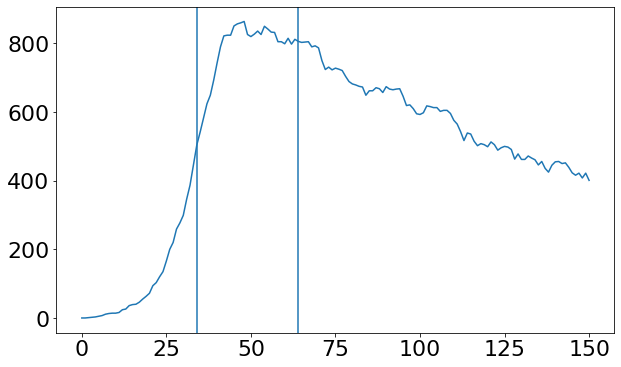

In [30]:
t = data['t']; 
y_plot = np.sum ( data['X'][:,4*M:7*M], axis = -1)

fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(t,y_plot)
ax.axvline(data['events_occured'][0][0])
ax.axvline(data['events_occured'][0][0]+30)
plt.show(fig)
plt.close(fig)

[[33.97990719584088, 1]]


0.0

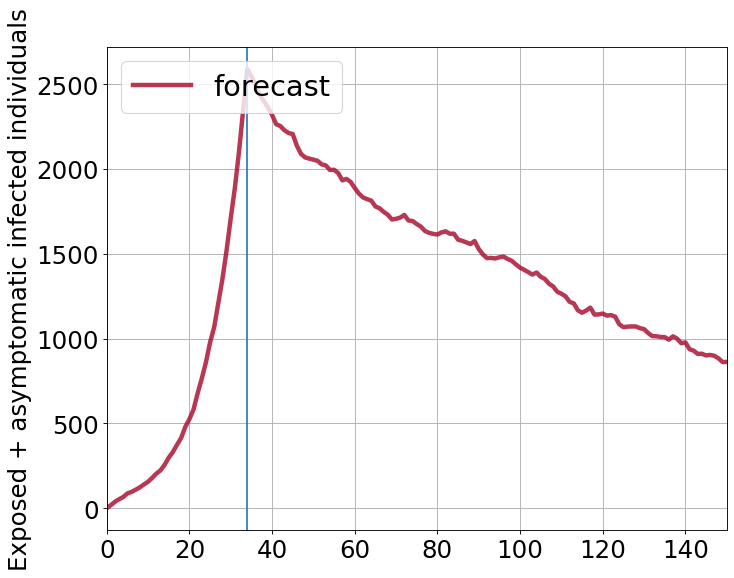

In [31]:

fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

plt.plot(t, IC, '-', lw=4, color='#A60628', label='forecast', alpha=0.8)
plt.axvline(data['events_occured'][0][0])
print(data['events_occured'])
 
plt.legend(fontsize=26, loc='upper left'); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Exposed + asymptomatic infected individuals'); #plt.xlim(0, 40); plt.ylim(0, 9999);
#plt.savefig('/Users/rsingh/Desktop/2a.png', format='png', dpi=212)
IC[0]

In [32]:
# Run 50 simulations with this protocol
N_simulations = 50

data_results = np.zeros([N_simulations,Nf,M*9],
                        dtype=int)
lockdown_starts = np.zeros(N_simulations)
for i in range(N_simulations):
    print('Running simulation {0} of {1}'.format(i+1,N_simulations),end='\r')
    data=model.simulate(S_0, E_0, A_0, Ia_0, Is_0, Ih_0, Ic_0, Im_0,
                    events,contactMatrices, Tf, Nf,
                                method='gillespie')
    data_results[i] = data['X']
    try:
        lockdown_starts[i] = data['events_occured'][0][0]
    except:
        print("no lockdown in simulation {0}".format(i+1))

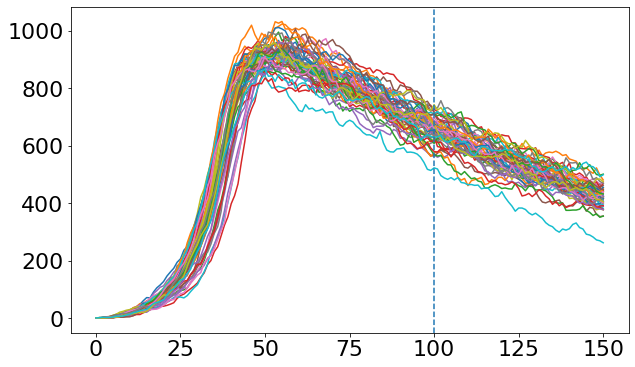

In [35]:
t = data['t']; 

fig,ax = plt.subplots(1,1,figsize=(10,6))
for i,e in enumerate(data_results):
    y_plot = np.sum ( e[:,4*M:7*M], axis = -1)
    ax.plot(t,y_plot)
ax.axvline(100,ls='--')
plt.show(fig)
plt.close(fig)